# Simulador de Ejes
### Ian Gross Sánchez

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid as cumtrapz

## Moments of Inertia

In [47]:
cross = 'solid_circular'
D = float(0.02) # Circular diameter [m]
# 0.02 da para un AISI4140 (Resistencia a la tensión de 1770 MPa)
# 0.025 da para un AISI1040 (Resistencia a la tensión de 700 MPa)
r = D / 2  # Circular radius [m]
C = 1.33  # Shear correction factor for circular section
I = np.pi * r**4 / 4  # Moment of inertia [m^4]
J = np.pi * r**4 / 2  # Polar moment of inertia [m^4]
A = np.pi * r**2  # Cross-sectional area [m^2]
y_max = r  # Maximum distance from the neutral axis to the outer fiber [m]
Q = np.pi * r**3 / 2  # First moment of area [m^3]
print(Q)

1.5707963267948969e-06


## Material Properties

In [48]:
#####################
# Material properties
#####################
name = 'AISI4140'
type = 'steel'

#######################
# Mechanical properties
#######################
rho = 7850  # Density [kg/m^3]
sigma_tension = 1770  # Yield strength [MPa]

E = 210*10**9           # Young's modulus [Pa]
nu = 0.3                # Poisson's ratio
G = E / (2 * (1 + nu))  # Shear modulus [Pa]


## Geometry

In [49]:
##########
# Geometry
##########
# Coordinate system
# y ^
#   |
# z o---> x
g = 9.81  # Gravity [m/s^2]


######
# Beam
######
positions = [
    (0.00, 'Apoyo Simple'), # 1
    (0.02, 'Engrane Recto'), # 2
    (0.02 + 0.07, 'Engrane Epicíclico'), # 3
    (0.02 + 0.07 + 0.07, 'Engrane Epicíclico'), # 4
    (0.02 + 0.07 + 0.07 + 0.07, 'Apoyo Simple') # 5
]

L = positions[-1][0]  # Beam Length [m]
x = np.linspace(0, L, 1000) # Discretization


#########
# Weights
#########
# Cilindro Sólido
def gear_weight(d_mm, e_mm):
    r = d_mm / 2000  # Radio [m]
    e_m = e_mm / 1000 # Espesor [m]
    volume = np.pi * r**2 * e_m
    mass = rho * volume
    return mass * g 

e = 60      # Espesor de cara [mm]

# 0
D_E0 = 236  # Engrane Recto [mm]
# 1
D_ES1 = 72  # Engrane Epicíclico 1 - Sol [mm]
D_EP1 = 84  # Engrane Epicíclico 1 - Planeta [mm]
D_EC1 = 240  # Engrane Epicíclico 1 - Corona [mm]
# 2
D_ES2 = 168  # Engrane Epicíclico 2 - Sol [mm]
D_EP2 = 68  # Engrane Epicíclico 2 - Planeta [mm]
D_EC2 = 304  # Engrane Epicíclico 2 - Corona [mm]

# Pesos individuales
W_g0 = gear_weight(D_E0, e)  # Engrane Recto
W_g1 = gear_weight(D_EC1, e)  # Engrane Epicíclico pequeño
W_g2 = gear_weight(D_EC2, e)  # Engrane Epicíclico grande

# Asignar pesos a posiciones
weight_map = {
    1: W_g0,  # Engrane Recto
    2: W_g1,  # Engrane Epicíclico 1
    3: W_g2   # Engrane Epicíclico 2
}


r_CM0 = (D_E0 / 3) / 1000 # Radio del centroide [m] - 2/3 R = D/3
r_CM1 = (D_EC1/2)/1000 # Radio del centroide [m] - Corona
r_CM2 = (D_EC2/2) / 1000 # Radio del centroide [m] - Corona

radii_map = {
    1: r_CM0,  # Engrane Recto
    2: r_CM1,  # Engrane Epicíclico 1
    3: r_CM2   # Engrane Epicíclico 2
}

#################
# Informe
#################
print("El largo de la barra es:", round(L, 3), "m")
print("Elementos en la barra:")

for i, (p, msg) in enumerate(positions):
    line = f"{i+1}. {msg} en la posición {round(p * 1000, 2)} mm"
    if i in weight_map:
        w = weight_map[i]
        line += f" - Peso: {round(w, 2)} N"
        r = radii_map[i]
        line += f" - Radio del centroide: {round(r, 2)} m"

    print(line)


El largo de la barra es: 0.23 m
Elementos en la barra:
1. Apoyo Simple en la posición 0.0 mm
2. Engrane Recto en la posición 20.0 mm - Peso: 202.12 N - Radio del centroide: 0.08 m
3. Engrane Epicíclico en la posición 90.0 mm - Peso: 209.03 N - Radio del centroide: 0.12 m
4. Engrane Epicíclico en la posición 160.0 mm - Peso: 335.37 N - Radio del centroide: 0.15 m
5. Apoyo Simple en la posición 230.0 mm


## Support

In [50]:
# Supported - Supported Beam
# ------------
# ^         oo
support = 'supported-supported'

## Free Body Diagram

In [51]:
########
# Forces
########
# Trabajo Gravitacional
xW_g = np.array([positions[1][0], positions[2][0], positions[3][0]])  # x coordinates of weights [m]
W_g = np.array([weight_map.get(i, 0) for i in range(1, 4)])  # Weights [N]
# Trabajo Radial
xW_r = np.array([positions[1][0]])  # x coordinates of radial work [m]
W_r = np.array([1349.9]) # Radial Work [N]
# Trabajo Tangencial
xW_t = np.array([positions[1][0], positions[2][0], positions[3][0]])  # x coordinates of tangential work [m]
W_t = np.array([3708.8, 1227.25, 1771.97]) # Tangential Work [N]

#########
# Moments
#########
# Momento Torsional = Fuerza Tangencial * r_CM
xMT_t = np.array([positions[1][0], positions[2][0], positions[3][0]])  # x coordinates of tangential moment [m]
MT_t = W_t * np.array([radii_map[i] for i in range(1, 4)])  # Tangential Bending Moment [N*m]
# Momento Flector
# xMBz = np.array([positions[1][0], positions[2][0], positions[3][0]])  # x coordinate of Bending Moment [m]
# MBz = np.array([291.76, 81, 159.48])  # Bending Moment [N*m]


#################
# Generar Informe
#################
print("Análisis Dinámico\n")
# Fuerzas
print("Trabajo Gravitacional:")
for i, w in enumerate(W_g):
    print(f"W_g{i+1} =", round(w, 2), "N", "en x =", round(xW_g[i], 3), "m")
print("\nTrabajo Radial:")
for i, w in enumerate(W_r):
    print(f"W_r{i+1} =", round(w, 2), "N", "en x =", round(xW_r[i], 3), "m")
print("\nTrabajo Tangencial:")
for i, w in enumerate(W_t):
    print(f"W_t{i+1} =", round(w, 2), "N", "en x =", round(xW_t[i], 3), "m")
# Momentos Flectores
print("\nMomento Torsion Tangencial:")
for i, m in enumerate(MT_t):
    print(f"MF_t{i+1} =", round(m, 2), "Nm", "en x =", round(xW_t[i], 3), "m")


Análisis Dinámico

Trabajo Gravitacional:
W_g1 = 202.12 N en x = 0.02 m
W_g2 = 209.03 N en x = 0.09 m
W_g3 = 335.37 N en x = 0.16 m

Trabajo Radial:
W_r1 = 1349.9 N en x = 0.02 m

Trabajo Tangencial:
W_t1 = 3708.8 N en x = 0.02 m
W_t2 = 1227.25 N en x = 0.09 m
W_t3 = 1771.97 N en x = 0.16 m

Momento Torsion Tangencial:
MF_t1 = 291.76 Nm en x = 0.02 m
MF_t2 = 147.27 Nm en x = 0.09 m
MF_t3 = 269.34 Nm en x = 0.16 m


## Momento y Esfuerzos

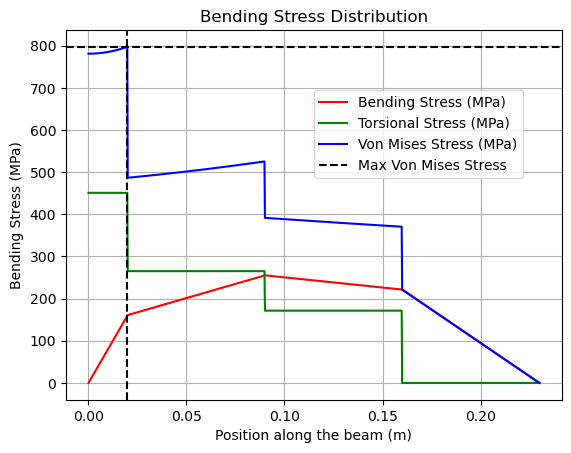

Maximum bending stress: 255.21 MPa at 0.09 m
Maximum torsion stress: 450.96 MPa at 0.00 m
Maximum Von Mises stress: 797.17 MPa at 0.02 m
Seguridad: 2.22 veces la resistencia a la tensión del material (AISI4140)


In [52]:
#######################
# Stress contribution x
#######################
MF = np.zeros_like(x, dtype=float) # Momento Flector
MT = np.zeros_like(x, dtype=float) # Momento Torsor

# Fuerzas
# Trabajo Gravitacional
for W_gi, xW_gi in zip(W_g, xW_g):
    MF += np.where(x < xW_gi, W_gi * (L - xW_gi) * x / L, W_gi * xW_gi * (L - x) / L)
# Trabajo Radial
for W_ri, xW_ri in zip(W_r, xW_r):
    MF += np.where(x < xW_ri, W_ri * (L - xW_ri) * x / L, W_ri * xW_ri * (L - x) / L)
# Trabajo Tangencial
for W_ti, xW_ti in zip(W_t, xW_t):
    MF += np.where(x < xW_ti, W_ti * (L - xW_ti) * x / L, W_ti * xW_ti * (L - x) / L)

# Momentos
for MT_ti, xMT_ti in zip(MT_t, xW_t):
    MT += MT_ti * (x <= xMT_ti)

# sigma_z
sigmaz = MF * y_max / I # Bending stress [Pa]
sigma_max = np.max(np.abs(sigmaz))*1e-6  # Maximum bending stress [MPa]
x_sigma_max = x[np.argmax(np.abs(sigmaz))]  # Position of maximum bending stress [m]

tau = MT * y_max / J  # Shear stress [Pa]
tau_max = np.max(np.abs(tau)) * 1e-6  # Maximum shear stress [MPa]
x_tau_max = x[np.argmax(np.abs(tau))]  # Position of maximum shear stress [m]

sigma_VonMises = np.sqrt(sigmaz**2 + 3 * tau**2)  # Von Mises stress [Pa]
sigma_VonMises_max = np.max(sigma_VonMises) * 1e-6  # Maximum Von Mises stress [MPa]
x_sigma_VonMises_max = x[np.argmax(sigma_VonMises)]  # Position of maximum Von Mises stress [m]

#################
# Generar Informe
#################
plt.title('Bending Stress Distribution')
plt.xlabel('Position along the beam (m)')
plt.ylabel('Bending Stress (MPa)')
plt.plot(x, sigmaz * 1e-6, label='Bending Stress (MPa)', color='red')
plt.plot(x, tau * 1e-6, label='Torsional Stress (MPa)', color='green')
plt.plot(x, sigma_VonMises * 1e-6, label='Von Mises Stress (MPa)', color='blue')

plt.axhline(sigma_VonMises_max, color='black', linestyle='--', label='Max Von Mises Stress')
plt.axvline(x_sigma_VonMises_max, color='black', linestyle='--')

plt.grid()
# Legend at the middle right
plt.legend(loc=(0.5,0.6))
plt.show()

print(f'Maximum bending stress: {sigma_max:.2f} MPa at {x_sigma_max:.2f} m')
print(f'Maximum torsion stress: {tau_max:.2f} MPa at {x_tau_max:.2f} m')
print(f'Maximum Von Mises stress: {sigma_VonMises_max:.2f} MPa at {x_sigma_VonMises_max:.2f} m')
print(f"Seguridad: {sigma_tension / sigma_VonMises_max:.2f} veces la resistencia a la tensión del material ({name})")

##  Integración para Deflexión

In [53]:
# Stress sigma
theta0 = cumtrapz(MF / (E*I) + MT / (G*J), x, initial=0)
delta0 = cumtrapz(theta0, x, initial=0)

C2 = delta0[-1] / L
theta = -theta0 + C2
delta_bending = cumtrapz(theta, x, initial=0)

# Max Deflection
max_deflection_bending_mm = np.max(np.abs(delta_bending)) * 1e3
x_max = x[np.argmax(np.abs(delta_bending))]

print(f'Maximum deflection due to bending: {max_deflection_bending_mm:.2f} mm')
print(f'Critical point: {x_max:.2f} m')

Maximum deflection due to bending: 2.11 mm
Critical point: 0.10 m


## Plot

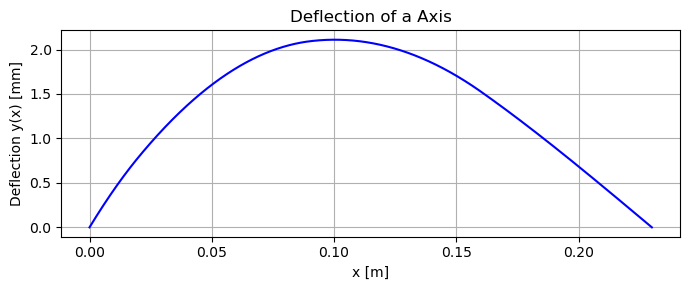

Support points = supported-supported
Cross-section: solid_circular, D: 0.02 m, I: 7.85e-09 m^4, J: 1.57e-08 m^4, A: 3.14e-04 m^2
Max deflection at x = 0.100 m: 2.110 mm


In [54]:
plt.figure(figsize=(7, 3))
plt.plot(x, delta_bending * 1e3, color="blue")  # Convert to mm
plt.title("Deflection of a Axis")
plt.xlabel("x [m]")
plt.ylabel("Deflection y(x) [mm]")
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Support points = {support}")
print(f"Cross-section: {cross}, D: {D} m, I: {I:.2e} m^4, J: {J:.2e} m^4, A: {A:.2e} m^2")
print(f"Max deflection at x = {x_max:.3f} m: {max_deflection_bending_mm:.3f} mm")

